<a href="https://colab.research.google.com/github/AndresMontesDeOca/RegresionAvanzada/blob/main/Machete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MACHETE

In [1]:
# Autor: Andres Montes de Oca

# Instalacion de Paquetes
!pip install pingouin # No incluido en Google Colab
# !pip install scipy
# !pip install statsmodels


# Cargamos Librerias y Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt


# Asthetics
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1, color_codes=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=45a850bf36c85aec36dae276bb65e58d3a54f3306657651cfd46d681c9ad83e7
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


## R Magic in Google Colab
## IN PROGRESS

In [2]:
# Version rpy2 que no tiene problemas de compatibilidad
!pip install rpy2==3.5.1

# activate R magic
%load_ext rpy2.ipython

# Import rpy2 for dataframe conversion
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import globalenv

# Cargamos un DataSet cualquira en Python, para que no de error
data_P = sns.load_dataset('iris')

# Convert the Python dataframe to the R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  data_R = ro.conversion.py2rpy(data_P)

globalenv['data_R'] = data_R # Create a variable name in R's global environment

# Convert R Dataframe to python dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  data_P = ro.conversion.rpy2py(data_R)

#check if ggplot2 is installed, if answer is different from an empty path is TRUE
%R print(system.file(package='ggplot2'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=318090 sha256=5c1ae9d1981293d59d9c69e5308c5b0c03d572c83f36a48ffe421641e6d70c3b
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5
[1] "/usr/lib/R/site-library/ggplot2"


/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


'/usr/lib/R/site-library/ggplot2'


#### Instalacion de Librerias para R en Google Colab

In [3]:
system(sudo apt install libgsl-dev)

['',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 4%',
 '',
 'Reading package lists... 4%',
 '',
 'Reading package lists... 4%',
 '',
 'Reading package lists... 4%',
 '',
 'Reading package lists... 43%',
 '',
 'Reading package lists... 43%',
 '',
 'Reading package lists... 43%',
 '',
 'Reading package lists... 43%',
 '',
 'Reading package lists... 47%',
 '',
 'Reading package lists... 54%',
 '',
 'Reading package lists... 54%',
 '',
 'Reading package lists... 63%',
 '',
 'Reading package lists... 63%',
 '',
 'Reading package lists... 68%',
 '',
 'Reading package lists... 68%',
 '',
 'Reading package lists... 68%',
 '',
 'Reading package lists... 68%',
 '',
 'Reading package lists... 68%',
 '',
 'Reading package lists... 68%',
 '',
 'Reading package lists... 68%',
 '',
 'Reading package lists... 68%',
 '',
 'Reading package lists... 78%',
 '',
 'Reading package lists... 78%',
 '',
 'Reading pack

In [4]:
%%R

# MVN Henze-Zirkler Test
# system(sudo apt install libgsl-dev)
install.packages('MVN')
library(MVN)
print(system.file(package='MVN'))

(as ‘lib’ is unspecified)













































































































	‘/tmp/RtmpDKrjXL/downloaded_packages’



[1] "/usr/local/lib/R/site-library/MVN"


## Cargas de Datasets from Google Drive

In [5]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


################################# Datasets ###################################
# Grasa de Cerdos
id = '153lGVzdixcHT-keKg8qmvaoWdPHg6_tB'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('grasacerdos.xlsx')
dataG = pd.read_excel('grasacerdos.xlsx', index_col='Obs') # Cargamos el Dataset
dataG = dataG.replace(to_replace=',', value='.', regex=True) # Reemplazo , por .
dataG = dataG.astype('float') # Transformo en float

# Peso, Edad, Colesterol son Modelo Lineal
id = '17Dv1WcWlc9ojWa6bnSfD7TCRaVKCKqj0'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('peso_edad_colest.xlsx')
dataP = pd.read_excel('peso_edad_colest.xlsx')
# Modelo Lineal para ejemplos
dataP = sm.add_constant(dataP)
model_colest = smf.ols('colest ~ edad', data=dataP).fit()

# Cars con Modelo Lineal
id = '15pf-6P4Ek2rp6mYmfOybHRqAxqOoTp6i'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('cars.csv')
dataC = pd.read_csv('cars.csv')
model_cars = smf.ols('dist ~ speed', data=dataC).fit()

# University
id = '16kLQNXhyweAi38xR2IeQCCagVcU725UZ'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('University.csv')
dataU = pd.read_csv('University.csv')

# Iris
dataI = sns.load_dataset('iris')

#### Logbook

In [ ]:
# 31/05/23 -> Creacion de la Notebook
# 31/05/23 -> 1, 2, 3, 4, 5
# 06/06/23 -> 6 - Correlacion de Residuos
# 17/06/23 -> 7 - Transfomraciones Box Clox
# 19/06/23 -> Migrated to Google Colab and R Magic Enabled

## Machete

### 1) Linear Relationship
Relationship between independent var (x) and depedent var (y) is linear

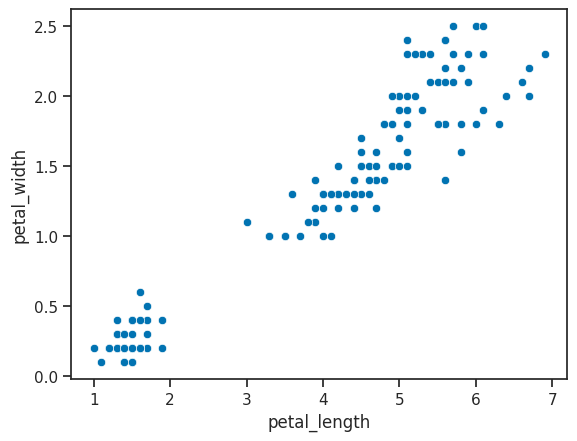

In [6]:
sns.scatterplot(data=dataI, x='petal_length', y='petal_width')
plt.show()

# Transformmations for making relationships linear. Polynomial or Exponential for any of both

### 2) Multicollonearity
Eeach independent variable should be independent from other independent variables

,n,r,CI95%,p-val,BF10,power
pearson,150,0.962865,"[0.95, 0.97]",4.675004e-86,1.113e+82,1.0


<ipython-input-7-eeee81c019ac>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(sns.heatmap(dataI.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos


<Axes: >

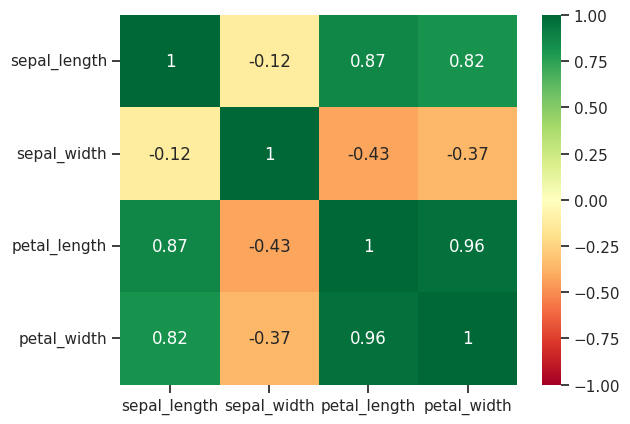

In [7]:
display(pg.corr(dataI['petal_length'], dataI['petal_width'], method='pearson')) # Entre dos varibales, H0 -> Variables Independientes
display(sns.heatmap(dataI.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos

### 3) Bi-Variate Normality
Multivariate Normality in Variables

#### Python

HZResults(hz=2.3363942003154383, pval=4.141311629927849e-19, normal=False)


,W,pval,normal
sepal_width,0.984917,0.101126,True


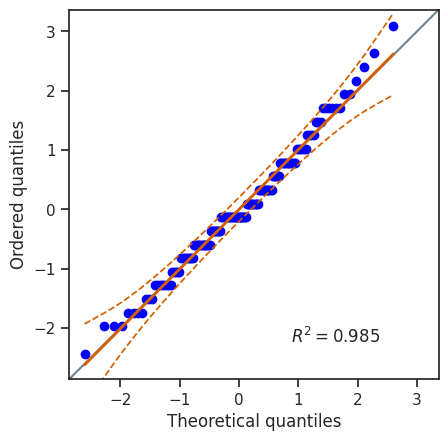

In [8]:
# Test analitico para Multi
print(pg.multivariate_normality(dataI.drop(columns='species'))) # Henze-Zirkler Test, H0 -> Multiv Normal Dist


# Tests analiticos para Single
display(pg.normality(dataI['sepal_width'])) # Shapiro Test(single Var), H0 -> Normal Dist

# Otros tests
# sm.stats.diagnostic.normal_ad(dataI['sepal_width']) # Anderson-Darling StatsModels
# st.anderson(dataI['sepal_width'], dist='norm') # Anderson-Darling SciPy
# st.kstest(dataI['sepal_width'], 'norm')# Kolmogorov-Smirnov SciPy

# Test grafico para Single
pg.qqplot(dataI['sepal_width']) # QQ Plot
plt.show()

#### R Magic

In [9]:
# Convert the Python dataframe to the R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
  data_R = ro.conversion.py2rpy(dataI.drop(columns='species'))

globalenv['data_R'] = data_R # Create a variable name in R's global environment

%R head(data_R)

/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4


In [12]:
%%R
library(MVN) # Henze-Zirkler test (Normalidad Multivariada)

hz <- mvn(data_R, mvnTest = "hz")
print(hz$multivariateNormality)

           Test       HZ p value MVN
1 Henze-Zirkler 2.336394       0  NO


### 4) Residuals Normality With 0 Mean
Model residuals should follow a normal distribution, with 0 as mean

In [ ]:
# Primero hay que generar el Modelo de Regresion Lineal
display(pg.normality(model_colest.resid))
print('Mean:', model_colest.resid.mean())

# If distribution is not normal, regression results will be biased
# and it may highlight that there are outliers or other assumptions being violated

### 5) Residuals Variance (Homosedasticity)
The variance of residual is the same for any value of x

In [ ]:
# Analsis grafico a mano usando Matplotlib
plt.scatter(x=model_colest.predict(), y=model_colest.resid)
plt.xlabel( 'Prediccion')
plt.ylabel('Residuo')
plt.title('Distribucion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura de embudo

# Analitico (Breusch-Pagan Test) -> H0: Residuos Homocedasticos
BP, p_value, _, _ =sm.stats.het_breuschpagan(model_colest.resid, model_colest.model.exog)
print('Estadistico BP y p-value:', BP, p_value)

# sns.residplot(data=dataP, x='edad', y='colest', lowess=True) # Pending
# Test White, Goldfeld-Quandt  Pending

### 6) Correlacion de Residuos
Aleatoriedad en el orden de las observacioens

In [ ]:
# Analsis grafico a mano usando Matplotlib
plt.scatter(x=dataP.index, y=model_colest.resid)
plt.xlabel( 'Index')
plt.ylabel('Residuo')
plt.title('Correlacion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura

# Durbin-Watson Test: 2=No Correlacion (Independecia?)| 0=Correlacion Pos | 4=Correlacion Neg
print('Durbin-Watson:', sm.stats.durbin_watson(model_colest.resid)) # Sin validacion Estadistica

## 7) Transformacion Box-Cox (pendiente IC e IP)
Cuando los residuos no siguen una distribucion Normal, transformamos la y

In [ ]:
# Verificamos la Normalidad de los residuos
print(st.shapiro(model_cars.resid))
data = dataC
y = data['dist']

# Box-Plot Transformation - Calculo Lambda
maxlog = st.boxcox(y)[1]
st.boxcox_normplot(y, -2, 2, plt)
plt.axvline(maxlog, color='red')
plt.show()

# Transfomracion: Si Lambda  = 0 -> np.log10(y) | y**Lambda
y_trans = pd.Series(y**.5, name='y_trans')
# No olvidarse de anti-transformar para los IC(10**predicted)

# Generamos el nuevo Dataset con la y transformada
data = pd.concat([data, y_trans], axis=1)

# Generamos el nuevo modelo con la y_transformada
model_cars_trans = smf.ols('y_trans ~ speed', data=data).fit()

# Verificamos la nueva normalidad de los residuos
print(pg.normality(model_cars_trans.resid))